# データサイエンス第12回
## AIの基礎（ニューラルネットワーク）

In [ ]:
# 必要に応じて次の行のコメントアウトを解除し，ライブラリをインストールしてください
!pip install --upgrade pip networkx seaborn torch　

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib 

from sklearn.model_selection import train_test_split
import seaborn as sns
import networkx as nx

#### 活性化関数 

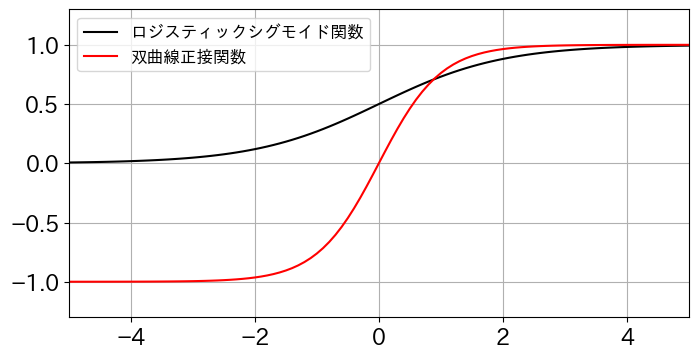

In [8]:
plt.figure(figsize=(8, 4))
u = np.linspace(-5, 5, 101)
y1 = 1 / (1 + np.exp(-u))
y2 = np.tanh(u)
plt.plot(u, y1, color='black', ls='-', label="ロジスティックシグモイド関数")
plt.plot(u, y2, color='red', ls='-', label="双曲線正接関数")
plt.xlim(-5, 5)
plt.ylim(-1.3, 1.3)
plt.grid()
plt.tick_params(labelsize=16)
plt.legend(loc="upper left", fontsize=12)
plt.show()

#### 順伝搬型ネットワーク

In [10]:
def softmax(x):
    x_shift = x - np.max(x, axis=1, keepdims=True) 
    exp_x = np.exp(x_shift)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

input_dim = 4
hidden_dim = 8 
output_dim = 2
seed = 42

N = 100
X = np.random.uniform(0, 1, size=(N, input_dim))
y = np.random.randint(0, 2, N)

rng = np.random.RandomState(seed)
W2 = rng.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
b2 = np.zeros((1, hidden_dim))
W3 = rng.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
b3 = np.zeros((1, output_dim))

u2 = X @ W2 + b2
z2 = np.tanh(u2)
u3 = z2 @ W3 + b3 
z3 = softmax(u3)  

/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/2202006685.py:21: RuntimeWarning: divide by zero encountered in matmul
  u2 = X @ W2 + b2
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/2202006685.py:21: RuntimeWarning: overflow encountered in matmul
  u2 = X @ W2 + b2
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/2202006685.py:21: RuntimeWarning: invalid value encountered in matmul
  u2 = X @ W2 + b2


#### 損失の計算

In [11]:
def one_hot(y, num_classes):
    oh = np.zeros((y.size, num_classes))
    oh[np.arange(y.size), y] = 1
    return oh

y = np.random.randint(0, 2, N)

y_one_hot = one_hot(y, z3.shape[1])
log_probs = np.log(z3 + 1e-8)
loss = -np.sum(y_one_hot * log_probs) / y.shape[0]

#### 誤差逆伝播法

In [12]:
lr = 0.01

y_one_hot = one_hot(y, z3.shape[1])

# 出力層の勾配 (softmax + cross-entropy)
dz3 = (z3 - y_one_hot) / X.shape[0]
dW3 = z2.T @ dz3
db3 = np.sum(dz3, axis=0, keepdims=True)

# 隠れ層の勾配
dz2 = (1 - np.tanh(u2) ** 2) * (dz3 @ W3.T)
dW2 = X.T @ dz2
db2 = np.sum(dz2, axis=0, keepdims=True)

# パラメータ更新
W3 -= lr * dW3
b3 -= lr * db3
W2 -= lr * dW2
b2 -= lr * db2

/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/3235855893.py:11: RuntimeWarning: divide by zero encountered in matmul
  dz2 = (1 - np.tanh(u2) ** 2) * (dz3 @ W3.T)
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/3235855893.py:11: RuntimeWarning: overflow encountered in matmul
  dz2 = (1 - np.tanh(u2) ** 2) * (dz3 @ W3.T)
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/3235855893.py:11: RuntimeWarning: invalid value encountered in matmul
  dz2 = (1 - np.tanh(u2) ** 2) * (dz3 @ W3.T)


#### データの読み込み

サンプル数: 234 特徴量次元: 4
クラス数: 2


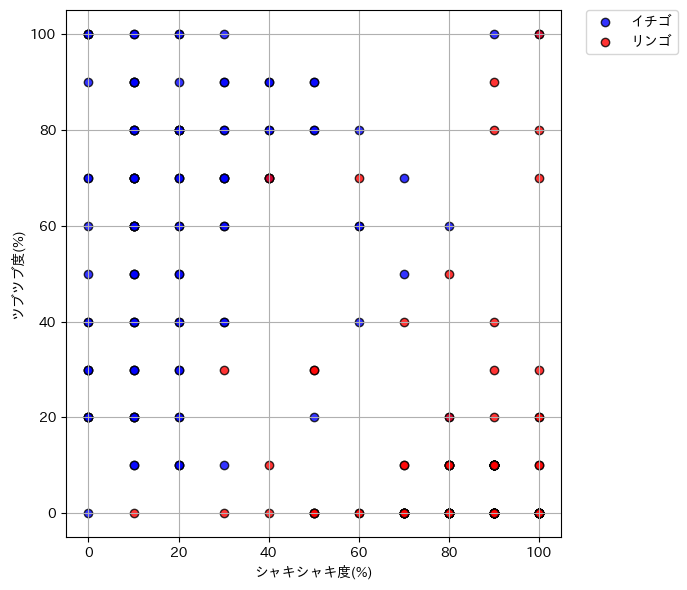

In [13]:
data = pd.read_csv("lecture12.csv").values

y = data[:, 0].astype(int)
X_raw = data[:, 1:]
X = X_raw.copy()

N, D = X.shape
print("サンプル数:", N, "特徴量次元:", D)

# 特徴量を 0〜1 にスケーリング（0〜100% → 0〜1）
X = X / 100.0

num_classes = len(np.unique(y))
print("クラス数:", num_classes)


plt.figure(figsize=(7, 6))

labels = {0: "イチゴ", 1: "リンゴ"}
colors = {0: "blue", 1: "red"}

crisp = X_raw[:, 2]   # シャキシャキ度
grain = X_raw[:, 3]   # ツブツブ度

for c in np.unique(y):
    idx = (y == c)
    plt.scatter(
        crisp[idx], grain[idx],
        label=labels[c],
        color=colors[c],
        edgecolor="black",
        alpha=0.8
    )

plt.xlabel("シャキシャキ度(%)")
plt.ylabel("ツブツブ度(%)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


#### 2層ニューラルネットワークの定義

In [14]:
class TwoLayerNet:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.01, seed=42):
        rng = np.random.RandomState(seed)
        self.W2 = rng.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
        self.b2 = np.zeros((1, hidden_dim))
        self.W3 = rng.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
        self.b3 = np.zeros((1, output_dim))
        self.lr = lr

    def _softmax(self, x):
        x_shift = x - np.max(x, axis=1, keepdims=True) 
        exp_x = np.exp(x_shift)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def _one_hot(self, y, num_classes):
        oh = np.zeros((y.size, num_classes))
        oh[np.arange(y.size), y] = 1
        return oh

    def forward(self, X):
        self.u2 = X @ self.W2 + self.b2
        self.z2 = np.tanh(self.u2)
        self.u3 = self.z2 @ self.W3 + self.b3
        self.y_hat = self._softmax(self.u3)
        return self.y_hat

    def compute_loss(self, y_true):
        N = y_true.shape[0]
        y_one_hot = self._one_hot(y_true, self.y_hat.shape[1])
        log_probs = np.log(self.y_hat + 1e-8)
        loss = -np.sum(y_one_hot * log_probs) / N
        return loss

    def backward(self, X, y_true):
        N = X.shape[0]
        y_one_hot = self._one_hot(y_true, self.y_hat.shape[1])

        # 出力層の勾配 (softmax + cross-entropy)
        dz3 = (self.y_hat - y_one_hot) / N
        dW3 = self.z2.T @ dz3
        db3 = np.sum(dz3, axis=0, keepdims=True)

        # 隠れ層の勾配
        dz2 = (1 - np.tanh(self.u2) ** 2) * (dz3 @ self.W3.T)
        dW2 = X.T @ dz2 
        db2 = np.sum(dz2, axis=0, keepdims=True) 

        # パラメータ更新
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


def get_pos(idx, input_dim, hidden_dim, output_dim):
    if idx < input_dim:  # 入力層
        return (0.0, (idx + 1) / (input_dim + 1))
    elif idx < input_dim + hidden_dim:  # 隠れ層
        j = idx - input_dim
        return (0.5, (j + 1) / (hidden_dim + 1))
    else:  # 出力層
        k = idx - input_dim - hidden_dim
        return (1.0, (k + 1) / (output_dim + 1))


def build_graph(input_dim, hidden_dim, output_dim):
    G = nx.DiGraph()

    for i in range(input_dim + hidden_dim + output_dim):
        G.add_node(i)

    # 入力層 → 隠れ層 のエッジ
    for i in range(input_dim):
        for j in range(hidden_dim):
            G.add_edge(i, input_dim + j, weight=1.0)

    # 隠れ層 → 出力層 のエッジ
    for j in range(hidden_dim):
        for k in range(output_dim):
            G.add_edge(input_dim + j, input_dim + hidden_dim + k, weight=1.0)

    return G


def draw_network(G, model, input_dim, hidden_dim, output_dim, title="2層NNの構造"):
    # ノード位置
    pos = {n: get_pos(n, input_dim, hidden_dim, output_dim) for n in G.nodes}

    edge_color = []

    W2 = model.W2 
    W3 = model.W3

    # --- 入力層 → 隠れ層 のエッジ ---
    for i in range(input_dim):
        for j in range(hidden_dim):
            w = W2[i, j] 
            if w >= 0.8:
                edge_color.append('r')
            elif 0.4 <= w < 0.8:
                edge_color.append('lightcoral')
            elif 0.1 <= w < 0.4:
                edge_color.append('mistyrose')
            elif -0.4 < w <= -0.1:
                edge_color.append('lavender')
            elif -0.8 < w <= -0.4:
                edge_color.append('cornflowerblue')
            elif w <= -0.8:
                edge_color.append('b')
            else:
                edge_color.append('w')

    # --- 隠れ層 → 出力層 のエッジ ---
    for j in range(hidden_dim):
        for k in range(output_dim):
            w = W3[j, k]
            if w >= 0.8:
                edge_color.append('r')
            elif 0.4 <= w < 0.8:
                edge_color.append('lightcoral')
            elif 0.1 <= w < 0.4:
                edge_color.append('mistyrose')
            elif -0.4 < w <= -0.1:
                edge_color.append('lavender')
            elif -0.8 < w <= -0.4:
                edge_color.append('cornflowerblue')
            elif w <= -0.8:
                edge_color.append('b')
            else:
                edge_color.append('w')

    widths = [G[u][v]['weight'] for u, v in G.edges()]

    plt.figure(figsize=(8, 6))
    nx.draw_networkx(
        G,
        pos=pos,
        node_color="k",
        edge_color=edge_color,
        width=widths,
        with_labels=False
    )
    plt.title(title, fontsize=24)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

#### ネットワークの初期化

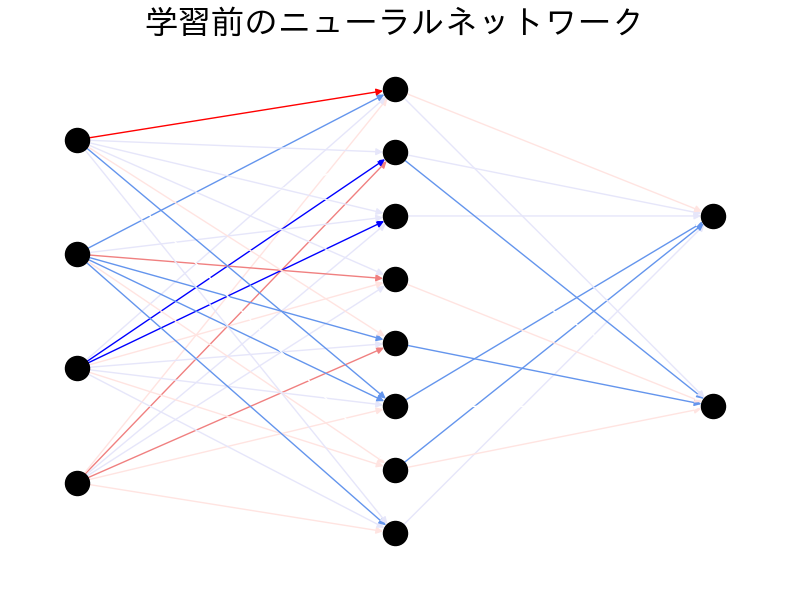

In [15]:
input_dim = D
hidden_dim = 8
output_dim = num_classes
learning_rate = 0.01
num_epochs = 500

model = TwoLayerNet(input_dim, hidden_dim, output_dim, lr=learning_rate)

G = build_graph(input_dim, hidden_dim, output_dim)
draw_network(G, model, input_dim, hidden_dim, output_dim, title="学習前のニューラルネットワーク")

#### 学習

epoch   10, loss=0.8729, acc=0.171
epoch   20, loss=0.8424, acc=0.205
epoch   30, loss=0.8140, acc=0.248
epoch   40, loss=0.7876, acc=0.274
epoch   50, loss=0.7628, acc=0.350
epoch   60, loss=0.7394, acc=0.419
epoch   70, loss=0.7174, acc=0.466
epoch   80, loss=0.6965, acc=0.534
epoch   90, loss=0.6767, acc=0.598
epoch  100, loss=0.6578, acc=0.684
epoch  110, loss=0.6397, acc=0.786
epoch  120, loss=0.6224, acc=0.859
epoch  130, loss=0.6058, acc=0.880
epoch  140, loss=0.5899, acc=0.910
epoch  150, loss=0.5746, acc=0.932
epoch  160, loss=0.5598, acc=0.944
epoch  170, loss=0.5456, acc=0.944
epoch  180, loss=0.5318, acc=0.944
epoch  190, loss=0.5186, acc=0.940
epoch  200, loss=0.5057, acc=0.940
epoch  210, loss=0.4934, acc=0.944
epoch  220, loss=0.4814, acc=0.944
epoch  230, loss=0.4699, acc=0.949
epoch  240, loss=0.4587, acc=0.949
epoch  250, loss=0.4479, acc=0.949
epoch  260, loss=0.4374, acc=0.949
epoch  270, loss=0.4273, acc=0.953
epoch  280, loss=0.4176, acc=0.953
epoch  290, loss=0.4

/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:21: RuntimeWarning: divide by zero encountered in matmul
  self.u2 = X @ self.W2 + self.b2
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:21: RuntimeWarning: overflow encountered in matmul
  self.u2 = X @ self.W2 + self.b2
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:21: RuntimeWarning: invalid value encountered in matmul
  self.u2 = X @ self.W2 + self.b2
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:44: RuntimeWarning: divide by zero encountered in matmul
  dz2 = (1 - np.tanh(self.u2) ** 2) * (dz3 @ self.W3.T)
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:44: RuntimeWarning: overflow encountered in matmul
  dz2 = (1 - np.tanh(self.u2) ** 2) * (dz3 @ self.W3.T)
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:44: RuntimeWarning: invalid value encountered 

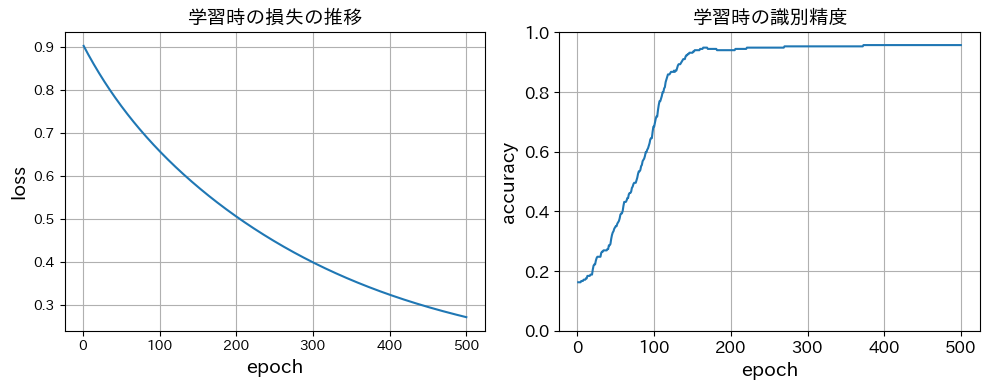

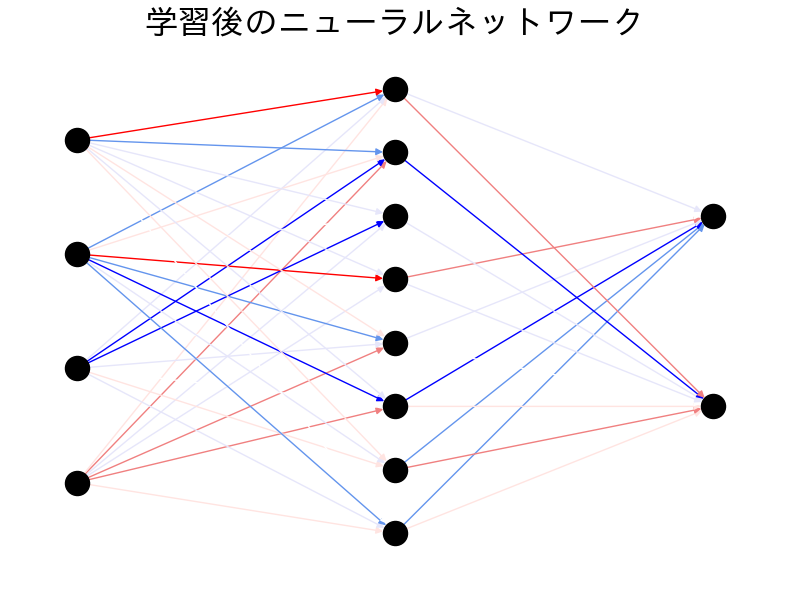

In [16]:
import matplotlib.pyplot as plt

loss_history = []
acc_history = []
epoch_history = []

for epoch in range(num_epochs):
    # 順伝播
    y_pred = model.forward(X)

    # 損失計算
    loss = model.compute_loss(y)

    # 逆伝播 & パラメータ更新
    model.backward(X, y)

    pred_labels = model.predict(X)
    acc = np.mean(pred_labels == y)

    loss_history.append(loss)
    acc_history.append(acc)
    epoch_history.append(epoch + 1)

    if (epoch + 1) % 10 == 0:
        print(f"epoch {epoch+1:4d}, loss={loss:.4f}, acc={acc:.3f}")

plt.figure(figsize=(10, 4))

# Loss の推移
plt.subplot(1, 2, 1)
plt.plot(epoch_history, loss_history)
plt.xlabel("epoch", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("学習時の損失の推移", fontsize=14)
plt.grid(True)

# Accuracy の推移
plt.subplot(1, 2, 2)
plt.plot(epoch_history, acc_history)
plt.xlabel("epoch", fontsize=14)
plt.ylabel("accuracy", fontsize=14)
plt.ylim(0, 1.0)
plt.title("学習時の識別精度", fontsize=14)
plt.grid(True)
plt.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

G = build_graph(input_dim, hidden_dim, output_dim)
draw_network(G, model, input_dim, hidden_dim, output_dim, title="学習後のニューラルネットワーク")

#### テスト

/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:21: RuntimeWarning: divide by zero encountered in matmul
  self.u2 = X @ self.W2 + self.b2
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:21: RuntimeWarning: overflow encountered in matmul
  self.u2 = X @ self.W2 + self.b2
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:21: RuntimeWarning: invalid value encountered in matmul
  self.u2 = X @ self.W2 + self.b2
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:23: RuntimeWarning: divide by zero encountered in matmul
  self.u3 = self.z2 @ self.W3 + self.b3
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:23: RuntimeWarning: overflow encountered in matmul
  self.u3 = self.z2 @ self.W3 + self.b3
/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/1308126435.py:23: RuntimeWarning: invalid value encountered in matmul
  self.u3 = self.z2 @ 

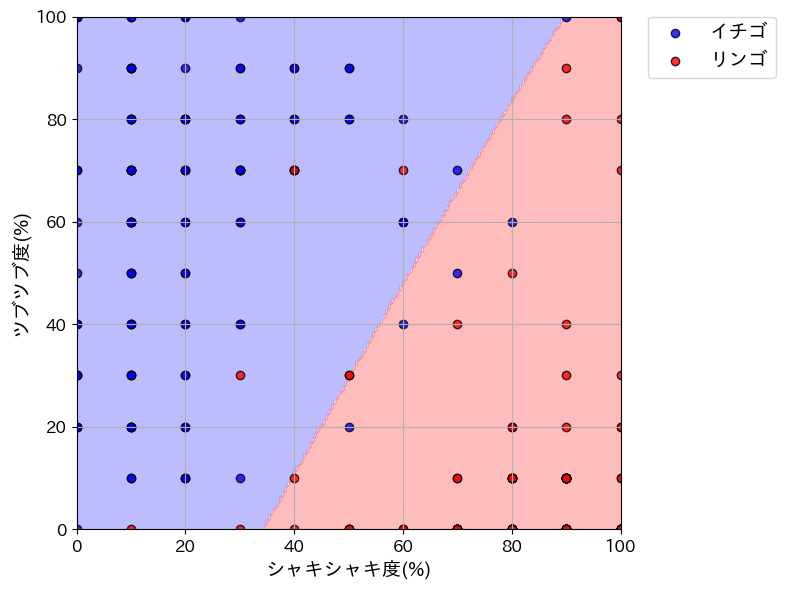

In [17]:
sweet_mean = np.mean(X_raw[:, 0]) / 100.0   # 0〜1
sour_mean  = np.mean(X_raw[:, 1]) / 100.0   # 0〜1

xx, yy = np.meshgrid(
    np.linspace(0, 100, 200),  # シャキシャキ
    np.linspace(0, 100, 200)   # ツブツブ
)

grid_points = np.c_[
    np.full(xx.size, sweet_mean),   # 甘さ（平均）
    np.full(xx.size, sour_mean),    # 酸っぱさ（平均）
    xx.ravel() / 100.0,             # シャキシャキ（0〜1）
    yy.ravel() / 100.0              # ツブツブ（0〜1）
]

probs = model.forward(grid_points)
Z_proba = probs[:, 1].reshape(xx.shape)

plt.figure(figsize=(8, 6))

Z_label = (Z_proba > 0.5).astype(int)
plt.contourf(xx, yy, Z_label, alpha=0.3, cmap="bwr")

crisp = X_raw[:, 2]
grain = X_raw[:, 3]

labels = {0: "イチゴ", 1: "リンゴ"}
colors = {0: "blue", 1: "red"}

for c in np.unique(y):
    idx = (y == c)
    plt.scatter(
        crisp[idx], grain[idx],
        label=labels[c],
        color=colors[c],
        edgecolor="black",
        alpha=0.8
    )

plt.xlabel("シャキシャキ度(%)", fontsize=14)
plt.ylabel("ツブツブ度(%)", fontsize=14)
plt.tick_params(labelsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, fontsize=14)
plt.tight_layout()
plt.show()

<span style="font-size: 20px; color: #F08000;">問題</span>

```py
penguins = sns.load_dataset('penguins').dropna()

X_raw = penguins[['bill_length_mm', 'bill_depth_mm']].values

# ラベル：種を 0,1,2 にエンコード
y = penguins['species'].replace({
    'Adelie': 0,
    'Chinstrap': 1,
    'Gentoo': 2
}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

X_raw = X_train
sp = ['Adelie', 'Chinstrap', 'Gentoo']
color = ["#FF3200", "#03AF7A", "#005AFF"]

X = X_raw.copy()
N, D = X.shape
print("サンプル数:", N, "特徴量次元:", D)

# --- 0〜1 に min-max スケーリング ---
X_min = X_raw.min(axis=0)
X_max = X_raw.max(axis=0)
X = (X_raw - X_min) / (X_max - X_min)

num_classes = len(np.unique(y))
print("クラス数:", num_classes)
```

In [30]:
##############################
# 問題のコードを記入
penguins = sns.load_dataset('penguins').dropna()

X_raw = penguins[['bill_length_mm', 'bill_depth_mm']].values

# ラベル：種を 0,1,2 にエンコード
y = penguins['species'].replace({
    'Adelie': 0,
    'Chinstrap': 1,
    'Gentoo': 2
}).values

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.5, random_state=42)

X_raw = X_train
y = y_train
sp = ['Adelie', 'Chinstrap', 'Gentoo']
color = ["#FF3200", "#03AF7A", "#005AFF"]

X = X_raw.copy()
N, D = X.shape
print("サンプル数:", N, "特徴量次元:", D)

# --- 0〜1 に min-max スケーリング ---
X_min = X_raw.min(axis=0)
X_max = X_raw.max(axis=0)
X = (X_raw - X_min) / (X_max - X_min)

num_classes = len(np.unique(y))
print("クラス数:", num_classes)
##############################

サンプル数: 166 特徴量次元: 2
クラス数: 3


/var/folders/w0/84vffvq953g73q80qyvcqrf40000gn/T/ipykernel_5187/357156194.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = penguins['species'].replace({


### ニューラルネットワークによる画像分類

PyTorchModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


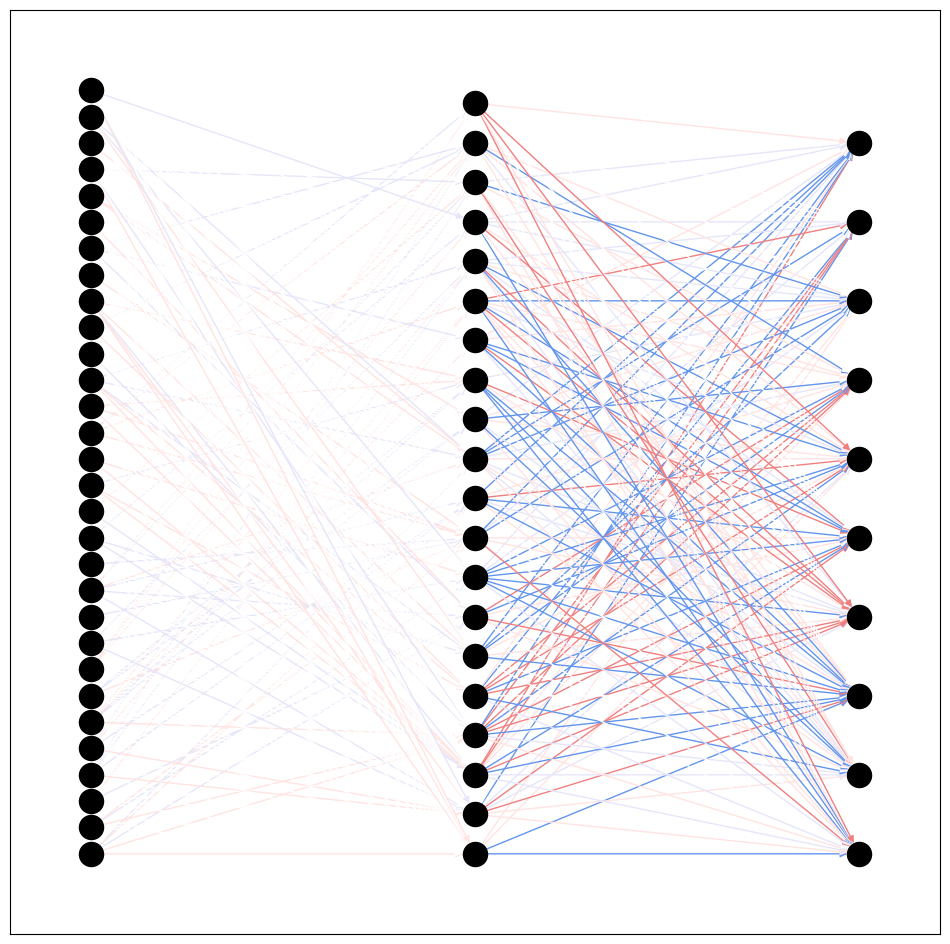

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import fetch_openml

def get_pos(x):
    if x < 30:
        return (0, 1 / 30 * x)
    elif 30 <= x < 30 + 20:
        return (0.3, 1 / 20 * (x - 30))
    else:
        return (0.6, 1 / 10 * (x - 30 - 20))

n1 = 28 * 28 
n2 = 128
n3 = 10

def draw_network(G, model, epoch):
    edges = G.edges()
    pos = {n: get_pos(i) for i, n in enumerate(G.nodes)}

    edge_color = []

    layer1_weights = model.fc1.weight.detach()
    layer2_weights = model.fc2.weight.detach()

    for i in range(30):
        for j in range(20):
            w = layer1_weights[j, i].item()
            if w >= 0.1:
                edge_color.append('r')
            elif 0.06 <= w < 0.1:
                edge_color.append('lightcoral')
            elif 0.03 <= w < 0.06:
                edge_color.append('mistyrose')
            elif -0.06 < w <= -0.03:
                edge_color.append('lavender')
            elif -0.1 < w <= -0.06:
                edge_color.append('cornflowerblue')
            elif w <= -0.1:
                edge_color.append('b')
            else:
                edge_color.append('w')

    for i in range(20):
        for j in range(10):
            w = layer2_weights[j, i].item()
            if w >= 0.1:
                edge_color.append('r')
            elif 0.06 <= w < 0.1:
                edge_color.append('lightcoral')
            elif 0.03 <= w < 0.06:
                edge_color.append('mistyrose')
            elif -0.06 < w <= -0.03:
                edge_color.append('lavender')
            elif -0.1 < w <= -0.06:
                edge_color.append('cornflowerblue')
            elif w <= -0.1:
                edge_color.append('b')
            else:
                edge_color.append('w')

    width = [G[u][v]['weight'] for u, v in edges]

    plt.figure(1, figsize=(12, 12))
    nx.draw_networkx(G, pos=pos, node_color="k", edge_color=edge_color, width=width)


G = nx.DiGraph()

# Add nodes
G.add_nodes_from(range(30))           
G.add_nodes_from(range(30, 30 + 20))  
G.add_nodes_from(range(30 + 20, 30 + 20 + 10)) 

# Add edges between layers
for i in range(30):
    for j in range(20):
        G.add_edge(i, j + 30, color='w', weight=1)

for i in range(20):
    for j in range(10):
        G.add_edge(i + 30, j + 30 + 20, color='w', weight=1)


class PyTorchModel(nn.Module):
    def __init__(self):
        super(PyTorchModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

pytorch_model = PyTorchModel()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.02)
loss_fn = nn.CrossEntropyLoss()

print(pytorch_model)

# Draw the network
draw_network(G, pytorch_model, 0)

### データセット読み込み

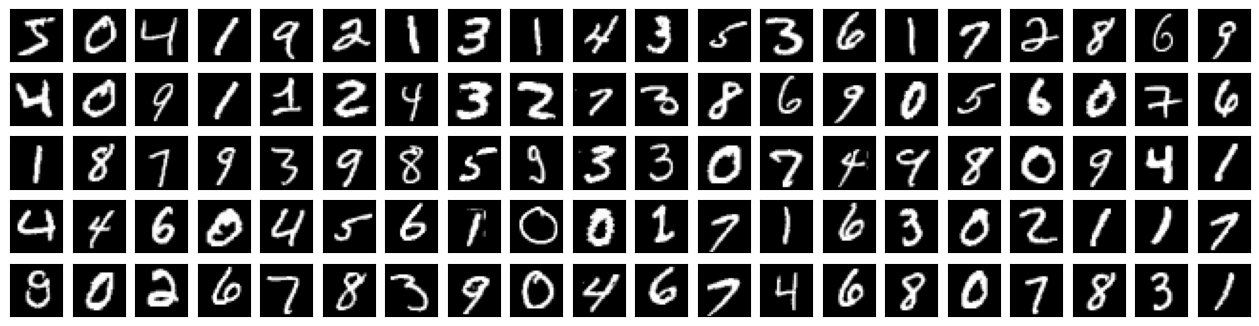

In [20]:
data = fetch_openml('mnist_784', version=1)
x, y = data.data, data.target
x = x.values.reshape(-1, 28, 28) / 255.0
x_train, x_test = x[:60000], x[60000:]
y_train, y_test = np.array(y[:60000], dtype=int), np.array(y[60000:], dtype=int)


demo_size = 100
fig = plt.figure(figsize=(16, 4))
ax = [fig.add_subplot(demo_size // 20, 20, i + 1) for i in range(demo_size)]
for i, a in enumerate(ax):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(x_train[i], cmap='gray')

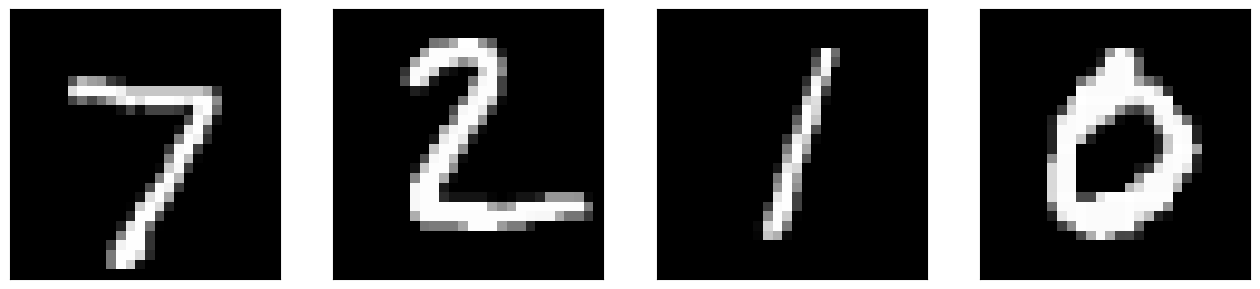

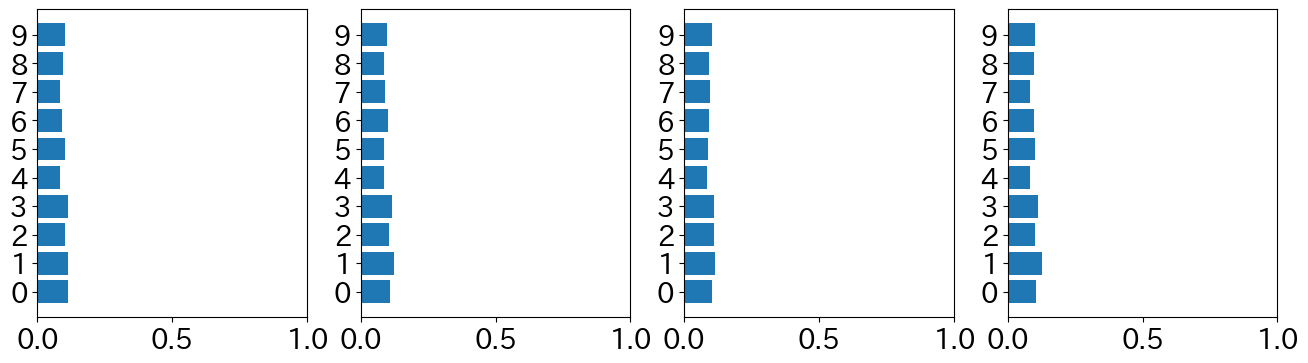

In [21]:
demo_size = 4
fig = plt.figure(figsize=(16, 5))
ax = [fig.add_subplot(1, demo_size, i + 1) for i in range(demo_size)]

for i, a in enumerate(ax):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(x_test[i], cmap='gray')

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig = plt.figure(figsize=(16, 4))
bx = [fig.add_subplot(1, demo_size, i + 1) for i in range(demo_size)]

pytorch_model.eval()
x_test_tensor = torch.tensor(x_test[:demo_size]).float()
pred = pytorch_model(x_test_tensor.view(-1, 28 * 28)).detach().numpy()

for i, a in enumerate(bx):
    bx[i].barh(x_ticks, pred[i])
    bx[i].set_xlim(0, 1)
    bx[i].set_yticks(x_ticks)
    bx[i].tick_params(labelsize=20)

### ニューラルネットワークの重みパラメータを学習

Epoch 1, Loss: 2.301973581314087
Epoch 2, Loss: 2.1644041538238525
Epoch 3, Loss: 1.9360992908477783


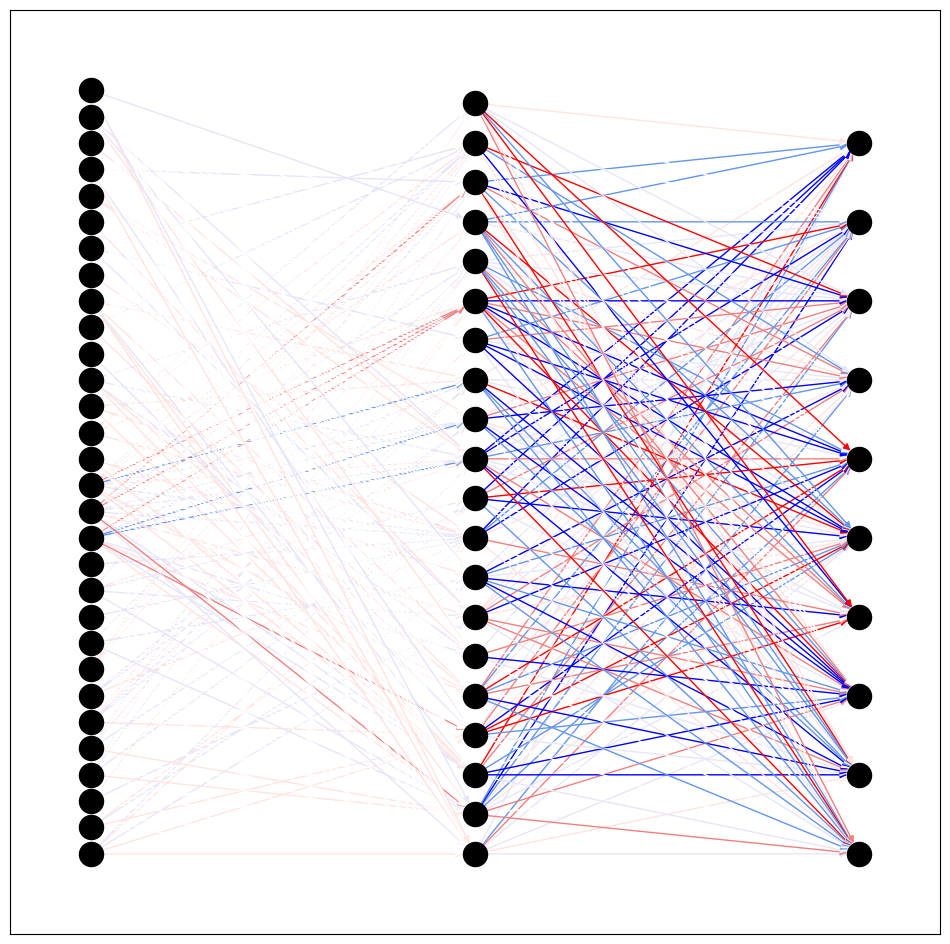

In [22]:
pytorch_model.train()
for epoch in range(3):
    x_train_tensor = torch.tensor(x_train).float()
    y_train_tensor = torch.tensor(y_train)

    optimizer.zero_grad()
    outputs = pytorch_model(x_train_tensor.view(-1, 28 * 28))
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

draw_network(G, pytorch_model, 0)

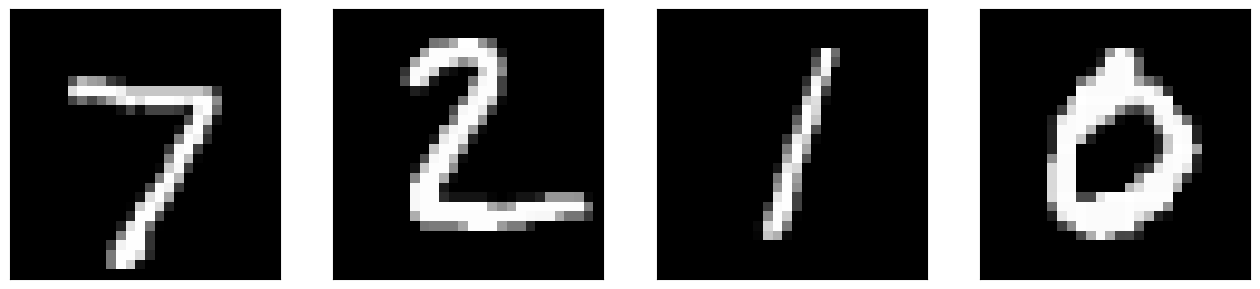

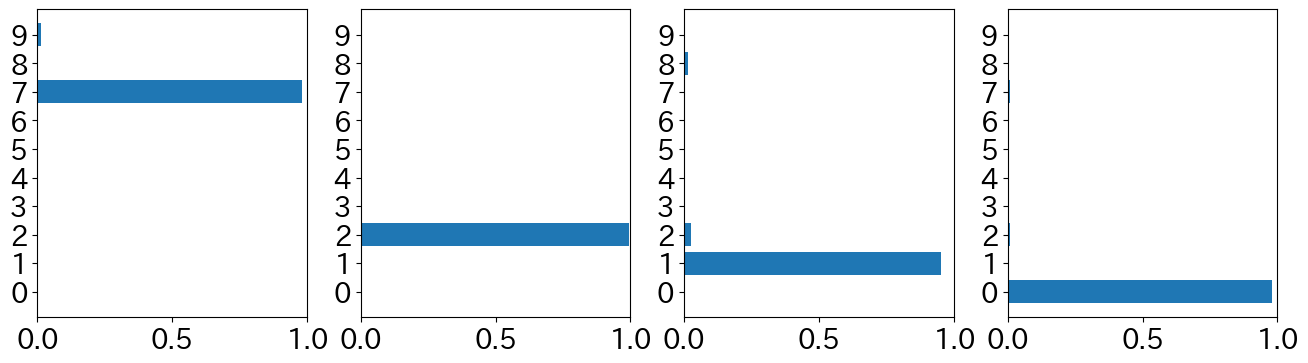

In [23]:
demo_size = 4
fig = plt.figure(figsize=(16, 5))
ax = [fig.add_subplot(1, demo_size, i + 1) for i in range(demo_size)]

for i, a in enumerate(ax):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(x_test[i], cmap='gray')

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig = plt.figure(figsize=(16, 4))
bx = [fig.add_subplot(1, demo_size, i + 1) for i in range(demo_size)]

pytorch_model.eval()
x_test_tensor = torch.tensor(x_test[:demo_size]).float()
pred = pytorch_model(x_test_tensor.view(-1, 28 * 28)).detach().numpy()

for i, a in enumerate(bx):
    bx[i].barh(x_ticks, pred[i])
    bx[i].set_xlim(0, 1)
    bx[i].set_yticks(x_ticks)
    bx[i].tick_params(labelsize=20)

In [24]:
pytorch_model.eval()
x_test_tensor = torch.tensor(x_test).float()
y_test_tensor = torch.tensor(y_test)
with torch.no_grad():
    test_outputs = pytorch_model(x_test_tensor.view(-1, 28 * 28))
    _, predictions = torch.max(test_outputs, 1)
    accuracy = (predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)

print('認識精度：{0:.1f}%'.format(accuracy * 100))

認識精度：69.6%


### ニューラルネットワークの重みパラメータをさらに学習

Epoch 1, Loss: 1.8458740711212158
Epoch 2, Loss: 1.7966302633285522
Epoch 3, Loss: 1.752899408340454
Epoch 4, Loss: 1.7469351291656494
Epoch 5, Loss: 1.7397980690002441
Epoch 6, Loss: 1.658492088317871
Epoch 7, Loss: 1.647861123085022
Epoch 8, Loss: 1.6294174194335938
Epoch 9, Loss: 1.6412241458892822
Epoch 10, Loss: 1.6171761751174927
Epoch 11, Loss: 1.5875685214996338
Epoch 12, Loss: 1.5919671058654785
Epoch 13, Loss: 1.587273120880127
Epoch 14, Loss: 1.581179141998291
Epoch 15, Loss: 1.577364206314087
Epoch 16, Loss: 1.5723600387573242
Epoch 17, Loss: 1.566650390625
Epoch 18, Loss: 1.5643978118896484
Epoch 19, Loss: 1.5638878345489502
Epoch 20, Loss: 1.5600351095199585
Epoch 21, Loss: 1.5549546480178833
Epoch 22, Loss: 1.5516406297683716
Epoch 23, Loss: 1.5500037670135498
Epoch 24, Loss: 1.5486186742782593
Epoch 25, Loss: 1.5466265678405762
Epoch 26, Loss: 1.5444971323013306
Epoch 27, Loss: 1.542744517326355
Epoch 28, Loss: 1.541003704071045
Epoch 29, Loss: 1.539209008216858
Epoch 3

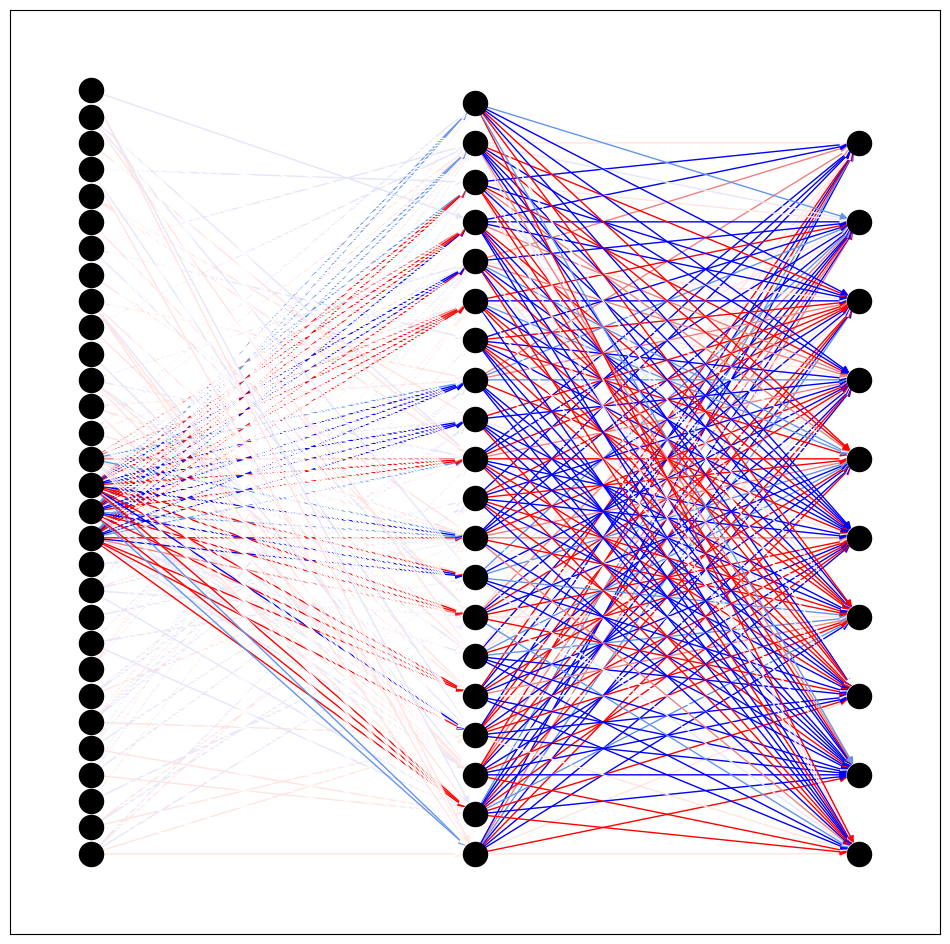

In [25]:
pytorch_model.train()
for epoch in range(200):
    x_train_tensor = torch.tensor(x_train).float()
    y_train_tensor = torch.tensor(y_train)

    optimizer.zero_grad()
    outputs = pytorch_model(x_train_tensor.view(-1, 28 * 28))
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

draw_network(G, pytorch_model, 0)

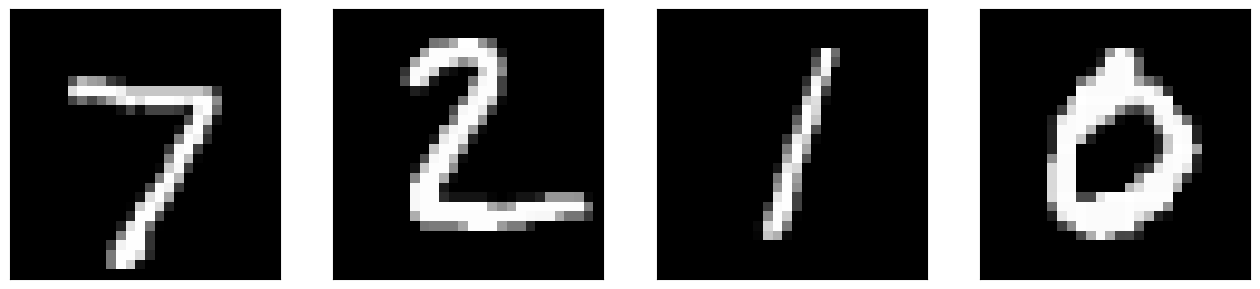

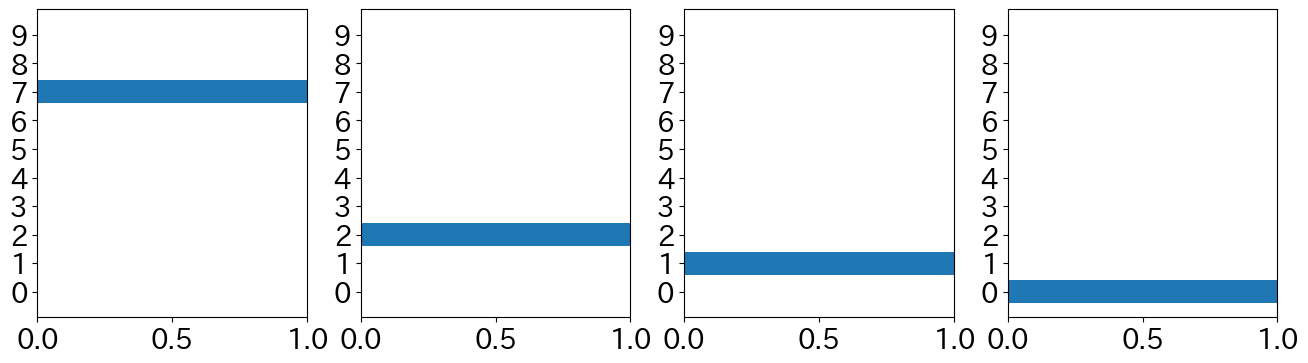

In [26]:
demo_size = 4
fig = plt.figure(figsize=(16, 5))
ax = [fig.add_subplot(1, demo_size, i + 1) for i in range(demo_size)]

for i, a in enumerate(ax):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(x_test[i], cmap='gray')

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig = plt.figure(figsize=(16, 4))
bx = [fig.add_subplot(1, demo_size, i + 1) for i in range(demo_size)]

pytorch_model.eval()
x_test_tensor = torch.tensor(x_test[:demo_size]).float()
pred = pytorch_model(x_test_tensor.view(-1, 28 * 28)).detach().numpy()

for i, a in enumerate(bx):
    bx[i].barh(x_ticks, pred[i])
    bx[i].set_xlim(0, 1)
    bx[i].set_yticks(x_ticks)
    bx[i].tick_params(labelsize=20)

In [27]:
pytorch_model.eval()
x_test_tensor = torch.tensor(x_test).float()
y_test_tensor = torch.tensor(y_test)
with torch.no_grad():
    test_outputs = pytorch_model(x_test_tensor.view(-1, 28 * 28))
    _, predictions = torch.max(test_outputs, 1)
    accuracy = (predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)

print('認識精度：{0:.1f}%'.format(accuracy * 100))

認識精度：96.6%
